In [1]:
"""
@File    : lab_notebook.ipynb
@Create  : 2024/12/13 16:24:19
@Modify  : 2024/12/13 16:24:19
@Author  : Flora Sun
@Contact : floras@animocabrands.com
@Desc    : None
"""

'\n@File    : lab_notebook.ipynb\n@Create  : 2024/12/13 16:24:19\n@Modify  : 2024/12/13 16:24:19\n@Author  : Flora Sun\n@Contact : floras@animocabrands.com\n@Desc    : None\n'

In [2]:
cd '/Users/floras/Desktop/unique-user'

/Users/floras/Desktop/unique-user


In [777]:
import pandas as pd
import numpy as np
import os
import importlib
import sybil_functions
import trino_fetch_results
from collections import Counter
from concurrent.futures import ThreadPoolExecutor
import networkx as nx
from cdlib import algorithms
import networkx as nx
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import OPTICS
from sklearn.ensemble import IsolationForest
import parameters
import matplotlib.pyplot as plt
import time
import datetime


importlib.reload(sybil_functions)
importlib.reload(trino_fetch_results)
importlib.reload(parameters)


from sybil_functions import (
    read_from_multiple_csv,
    stretched_sigmoid,
    file_name_lst,
    check_contract,
)

from trino_fetch_results import check_frequent_wallets, wallets_monthly_info, query_test

from parameters import trino_data_column_names

# Import Data

### Core wallet (airdrop wallet) 

In [4]:
# core wallet df
core_wallet_df = pd.read_csv(
    "/Users/floras/Desktop/unique-user/-Data/layerzero/lo_airdrop_wallets/used_airdrop_wallet_lst.csv"
)
print(core_wallet_df.shape)
core_wallet_df.head()

(10000, 1)


,address
0,0xfb10dcdce8fcb3423de4592aac91528ddf0a6b74
1,0x9dd711b0cb4430f429231e5cb9940dbd1952a36f
2,0x3efd66167df7b6e428809af37ab11e093792b544
3,0x67472806e0bb53329de922aaddd5988f60af3205
4,0xd2b4c8fc8180e9fabbaeea21d3e8cd3b1407280b


In [5]:
# Get core wallet list
core_wallet_lst_0 = core_wallet_df["address"].tolist()
# Get core wallet set
core_wallet_set_0 = set(core_wallet_lst_0)

### Sybil wallets 

In [6]:
# Sybil wallet df
sybil_wallet_df = pd.read_csv(
    "/Users/floras/Desktop/unique-user/-Data/layerzero/lo_sybil_wallets/used_sybil_wallet_lst.csv"
)
print(sybil_wallet_df.shape)
sybil_wallet_df.head()

(80000, 1)


,address
0,0x1e8f8f8d1eaba1864becbfb819be6e4f99b30b48
1,0x367298027b9fb5038924dc09b03f12f85c60827a
2,0x608ab11ea9f810403f96cd616955e34d73445aa1
3,0x6545f2395c8e013c18bd985d73a678fd4ce517dd
4,0x7f4ebe4e35066eac5a407d489e7972d9ef6b1a92


In [7]:
# Get sybil wallet list
sybil_wallet_lst_0 = sybil_wallet_df["address"].tolist()
# Get sybil wallet set
sybil_wallet_set_0 = set(sybil_wallet_lst_0)

In [8]:
core_sybil_wallet_lst = core_wallet_lst_0 + sybil_wallet_lst_0
# randomely select 1000 wallets from core_sybil_wallet_lst
# set seed
np.random.seed(8)
testing_wallet_lst = np.random.choice(core_sybil_wallet_lst, 58888, replace=False)
testing_wallet_set = set(testing_wallet_lst)
# check how many wallets are in the core wallet list
core_wallet_count = len(testing_wallet_set & core_wallet_set_0)
# check how many wallets are in the sybil wallet list
sybil_wallet_count = len(testing_wallet_set & sybil_wallet_set_0)

print(core_wallet_count)
print(sybil_wallet_count)

6550
52386


In [9]:
# generate new core wallet list
core_wallet_lst = [
    wallet for wallet in testing_wallet_lst if wallet in core_wallet_set_0
]
core_wallet_set = set(core_wallet_lst)
# generate new sybil wallet list
sybil_wallet_lst = [
    wallet for wallet in testing_wallet_lst if wallet in sybil_wallet_set_0
]
sybil_wallet_set = set(sybil_wallet_lst)

### Wallets to remove

In [10]:
removing_wallets_df_1 = pd.read_csv(
    "/Users/floras/Desktop/unique-user/-Data/layerzero/lo_removing_wallets/contract_wallets.txt",
    header=None,
)
removing_wallets_df_2 = pd.read_csv(
    "/Users/floras/Desktop/unique-user/-Data/layerzero/lo_removing_wallets/other_removing_wallets.txt",
    header=None,
)
removing_wallets_df = pd.concat([removing_wallets_df_1, removing_wallets_df_2], axis=0)
removing_wallets_df.columns = ["address"]

removing_wallets_df.head()

,address
0,0xdef171fe48cf0115b1d80b88dc8eab59176fee57
1,0xf9c4c674188089a7a5c608510360155147b9607b
2,0x7b36dfd5304562952e2b4de9c8048ed155c6115d
3,0xc4aff49fced8ac1d818a6dcab063f9f97e66ec5e
4,0xdb01f75c40fbf0b2684f9b7c9612e11674cb2330


In [11]:
# Get removing wallet list
removing_wallet_lst = removing_wallets_df["address"].tolist()
# Get removing wallet set
removing_wallet_set = set(removing_wallet_lst)

### Transaction data 

In [12]:
trans_df = pd.read_csv(
    "/Users/floras/Desktop/unique-user/-Data/layerzero/transaction_history/refined_transaction_sum_df.csv"
)
print(trans_df.shape)
# remove self transactions
trans_df = trans_df[trans_df["from_address"] != trans_df["to_address"]]
# remove removing-wallet transactions
trans_df = trans_df[
    ~(
        trans_df["from_address"].isin(removing_wallet_set)
        | trans_df["to_address"].isin(removing_wallet_set)
    )
]
# keep only core of sybil transactions
trans_df = trans_df[
    trans_df["from_address"].isin(core_wallet_set)
    | trans_df["to_address"].isin(core_wallet_set)
    | trans_df["from_address"].isin(sybil_wallet_set)
    | trans_df["to_address"].isin(sybil_wallet_set)
]
print(trans_df.shape)
trans_df.head()

(566626, 3)
(285447, 3)


,from_address,to_address,count
1,0x716759e8ab31cdb4bca2f693a979b23e6020d4bb,0xf5ceaa6b42c0eef37b0cc9f5a1dbc559df0a3509,862
3,0x716759e8ab31cdb4bca2f693a979b23e6020d4bb,0x71a3c8f3fe420806a6ea892c3ecd5aeb1f0a3509,748
5,0xfb7c1d49e006eaddff2385c7ef8b0c5cf49d038a,0xfab50c438f56a86d03439a5171452e3abf56a2c2,632
7,0xfb7c1d49e006eaddff2385c7ef8b0c5cf49d038a,0x8e925e8219fd9de16e2e007d06ad1f3bef56a2c2,544
12,0x11c6fef26abb8dfee23c2df67e9e60d120a48413,0xce6e06ae265a3f925444695571abf6583fb66efc,300


### Monthly data

In [13]:
trino_monthly_df = pd.read_csv(
    "/Users/floras/Desktop/unique-user/-Data/layerzero/monthly_info/processed_monthly_info_df.csv"
)
trino_monthly_df = trino_monthly_df.set_index("address")
print(trino_monthly_df.shape)
trino_monthly_df.head()

(229836, 5)


,gas_fee,total_txn,unique_tokens,last_txn_date,unique_active_days
address,,,,,
0x000000000000000000000000000000000000000a,0.043945,2,1,2024-02-20,1
0x00000000000007736e2f9aa5630b8c812e1f3fc9,272.652502,9754,4130,2024-06-30,218
0x00000000000062c6e2195ae26dff3b084c5c3938,5245.174636,517538,580,2024-06-25,118
0x00000000000ba9cd9f5175108141a82b6c24d727,8436.271954,11626,1,2024-06-30,186
0x00000000000e8716b4e2d12400a01474cdfad760,101607.258388,862227,1103,2024-01-30,187


# remove contract/hot wallets & transactions

## Define wallets to be checked based on the number of interacted wallets

In [14]:
def columns_unique_items(df, column_name_lst):
    unique_items = []
    for column_name in column_name_lst:
        unique_items.extend(df[column_name].unique().tolist())
    return list(set(unique_items))

In [15]:
all_wallets = columns_unique_items(trans_df, ["from_address", "to_address"])
print(len(all_wallets))

184868


In [16]:
def columns_item_count(unique_pairs_df, w_cols=["wallet_a", "wallet_b"]):
    # Flatten the selected columns into a single list
    wallet_z = unique_pairs_df[w_cols].values.flatten()
    # Count occurrences of each wallet using Counter
    wallet_z_count = Counter(wallet_z)
    # Convert the Counter object into a DataFrame
    wallet_z_count_df = pd.DataFrame(
        wallet_z_count.items(), columns=["wallet", "interacted_wallets"]
    )
    # Return the resulting DataFrame
    return wallet_z_count_df

In [17]:
def columns_item_unique_pairs(
    raw_transaction_df, address_cols=["from_address", "to_address"]
):
    # Ensure input columns are present in the DataFrame
    if not all(col in raw_transaction_df.columns for col in address_cols):
        raise ValueError(f"Columns {address_cols} not found in the DataFrame.")

    # Convert the columns to strings to ensure consistent dtype
    raw_transaction_df[address_cols] = raw_transaction_df[address_cols].astype(str)
    # Create sorted pairs using numpy operations (faster than apply)
    pairs = np.sort(raw_transaction_df[address_cols].to_numpy(dtype=str), axis=1)
    # Deduplicate pairs using numpy.unique
    unique_pairs = np.unique(pairs, axis=0)
    # Create a DataFrame for unique pairs
    unique_pairs_df = pd.DataFrame(unique_pairs, columns=["wallet_a", "wallet_b"])

    return unique_pairs_df

In [18]:
def columns_item_unique_pair_counts(
    raw_transaction_df, address_cols=["from_address", "to_address"]
):
    unique_pairs_df = columns_item_unique_pairs(raw_transaction_df, address_cols)
    # Use the optimized columns_item_count function
    wallet_count = columns_item_count(unique_pairs_df, w_cols=["wallet_a", "wallet_b"])
    # Reset index before returning
    wallet_count.reset_index(drop=True, inplace=True)
    return wallet_count

In [19]:
# sample_wallet_pair_count_df = columns_item_unique_pair_counts(native_trans_df_0)
# sample_wallet_pair_count_df.head()

In [20]:
# check_contract_wallet_lst = sample_wallet_pair_count_df[
#     sample_wallet_pair_count_df["interacted_wallets"] > 1
# ]["wallet"].tolist()
# check_contract_wallet_lst[:5]

In [21]:
def refine_lst(lst, exclude_lst):
    exclude_set = set(exclude_lst)
    return [x for x in lst if x not in exclude_set]

In [22]:
# # remove core wallets from check_contract_wallet_lst
# check_contract_wallet_lst = refine_lst(check_contract_wallet_lst, core_wallet_lst)

## get contract wallets list

In [23]:
def check_contract_wallet_addresses(wallet_addresses, max_threads=10):
    contract_wallets = []
    with ThreadPoolExecutor(max_threads) as executor:
        # Submit tasks for concurrent execution
        futures = [
            executor.submit(check_contract, wallet) for wallet in wallet_addresses
        ]
        for future in futures:
            results = future.result()
            if results:
                contract_wallets.append(results)
    return contract_wallets

In [24]:
# check_contract_wallet_addresses(check_contract_wallet_lst[:10])

## get hot wallets list

In [25]:
# check_frequent_wallets(
#     check_contract_wallet_lst[10:15], start_date_="2024-12-01", end_date_="2024-12-02"
# )

## remove contract/hot transactions

In [26]:
def filter_blacklist_transactions(df, col_lst, contract_lst):
    for col in col_lst:
        df = df[~df[col].isin(contract_lst)]
    return df

# Define weight

In [27]:
def columns_item_unique_pair_sums(
    raw_transaction_df_0,
    address_cols=["from_address", "to_address"],
    sum_col="tx_count",
):
    raw_transaction_df = raw_transaction_df_0.copy()
    raw_transaction_df["pair"] = raw_transaction_df[address_cols].apply(
        lambda x: tuple(sorted(x)), axis=1
    )
    unique_pair_sums = raw_transaction_df.groupby("pair")[sum_col].sum().reset_index()
    unique_pair_sums["node_a"] = unique_pair_sums["pair"].apply(lambda x: x[0])
    unique_pair_sums["node_b"] = unique_pair_sums["pair"].apply(lambda x: x[1])
    unique_pair_sums.drop(columns=["pair"], inplace=True)
    return unique_pair_sums

In [28]:
def sigmoid_weight_transform(df, turning_point=2, col="tx_count"):
    df["weight"] = df[col].apply(lambda x: stretched_sigmoid(x, 2 / turning_point))
    return df

In [29]:
trans_df["count"].describe()

count    285447.000000
mean          1.902290
std           4.548248
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         862.000000
Name: count, dtype: float64

In [30]:
trans_df

,from_address,to_address,count
1,0x716759e8ab31cdb4bca2f693a979b23e6020d4bb,0xf5ceaa6b42c0eef37b0cc9f5a1dbc559df0a3509,862
3,0x716759e8ab31cdb4bca2f693a979b23e6020d4bb,0x71a3c8f3fe420806a6ea892c3ecd5aeb1f0a3509,748
5,0xfb7c1d49e006eaddff2385c7ef8b0c5cf49d038a,0xfab50c438f56a86d03439a5171452e3abf56a2c2,632
7,0xfb7c1d49e006eaddff2385c7ef8b0c5cf49d038a,0x8e925e8219fd9de16e2e007d06ad1f3bef56a2c2,544
12,0x11c6fef26abb8dfee23c2df67e9e60d120a48413,0xce6e06ae265a3f925444695571abf6583fb66efc,300
...,...,...,...
566617,0x2b110fb95b780c5e410acfab169def735666133d,0x03ce1da719e39f9e6d72c15574f597052eb7e968,1
566621,0x2b110fb95b780c5e410acfab169def735666133d,0x03b989a218a7d808b3c88d986c0c2a0c30d9639e,1
566622,0x2b110fb95b780c5e410acfab169def735666133d,0x01351983178f696a2466a89fa0b5956d8ea222de,1
566623,0x82a8f96eb24993413ad7adf1f031fce984976a3e,0x1e72fd5929e64df37359ea644a46a9bf6614f3a5,1


In [31]:
columns_item_unique_pair_sums(trans_df, sum_col="count")

,count,node_a,node_b
0,2,0x0000000000000000000000000000000000002105,0x4b67945a88b434f22ec1308ad89769fd35127a5f
1,1,0x0000000000000000000000000000000064c8f444,0x81ab9d56c5a7f268a9ea5e3fe233771423754895
2,1,0x0000000000000000000000000000000066353a2b,0x4b67945a88b434f22ec1308ad89769fd35127a5f
3,1,0x000000000000000000000000000000009b476a5d,0x4b67945a88b434f22ec1308ad89769fd35127a5f
4,1,0x000000000000000000000000000000009b477880,0x4b67945a88b434f22ec1308ad89769fd35127a5f
...,...,...,...
264475,1,0xfecfcab98fd25c78049a1b567301e8437d0652c9,0xff5df410e4c72c1b49a2adfc3e3a8ef9511c9292
264476,2,0xfee0f7dd0df74723c681e23ff6c6410b4f23ff57,0xff8ba4d1fc3762f6154cc942ccf30049a2a0cec6
264477,1,0xff1cff02332f6f23c93551a3ef70d99cbb6fcc80,0xff629ead0ce217e4e99e1714e09be41dd387c1d8
264478,1,0xff8ba4d1fc3762f6154cc942ccf30049a2a0cec6,0xff994f1271ca94fd232b89adef52023b41fef4bf


In [32]:
weight_df = columns_item_unique_pair_sums(trans_df, sum_col="count")
# weight_df = sigmoid_weight_transform(weight_df, turning_point= 100, col='count')
weight_df["weight"] = weight_df["count"] / weight_df["count"].max()
print(weight_df.shape)
weight_df.head()

(264480, 4)


,count,node_a,node_b,weight
0,2,0x0000000000000000000000000000000000002105,0x4b67945a88b434f22ec1308ad89769fd35127a5f,0.00232
1,1,0x0000000000000000000000000000000064c8f444,0x81ab9d56c5a7f268a9ea5e3fe233771423754895,0.00116
2,1,0x0000000000000000000000000000000066353a2b,0x4b67945a88b434f22ec1308ad89769fd35127a5f,0.00116
3,1,0x000000000000000000000000000000009b476a5d,0x4b67945a88b434f22ec1308ad89769fd35127a5f,0.00116
4,1,0x000000000000000000000000000000009b477880,0x4b67945a88b434f22ec1308ad89769fd35127a5f,0.00116


<Axes: >

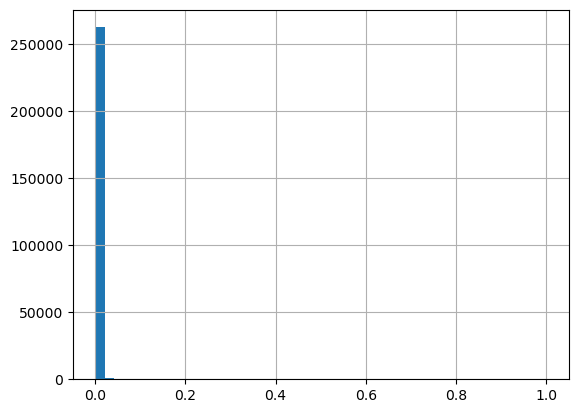

In [33]:
weight_df["weight"].hist(bins=50)

# build community

In [34]:
def louvain_community_lst_func(
    df, resolution=1, node_cols=["node_a", "node_b"], weight_col="weight"
):
    unique_wallets_num = len(columns_unique_items(df, node_cols))
    num_edges = df.shape[0]
    print(f"Number of unique wallets: {unique_wallets_num}")
    print(f"Number of edges: {num_edges}")

    # Create a graph
    G = nx.Graph()

    # Add edges to the graph
    for _, row in df.iterrows():
        G.add_edge(row[node_cols[0]], row[node_cols[1]], weight=row[weight_col])

    communities = algorithms.louvain(G, weight=weight_col, resolution=resolution)

    communities_list = communities.communities
    print(f"Number of communities detected: {len(communities_list)}")
    print("-")
    display(pd.Series([len(community) for community in communities_list]).describe())
    print("")

    communities_list = sorted(communities_list, key=lambda x: len(x), reverse=True)

    return communities_list

In [35]:
def nested_lst_to_loc_dict(nested_lst_):
    loc_dict = {}
    for i, commu in enumerate(nested_lst_):
        for w in commu:
            loc_dict[w] = i
    return loc_dict

### Decide Louvain resolution

In [384]:
commu_count_dict = {}
wallets_count_dict = {}

for r in range(1, 3000, 200):
    print(f"Resolution: {r}")
    louvain_community_lst = louvain_community_lst_func(weight_df, resolution=r)
    count = 0
    ttl_wallets = 0
    for i, commu_wallets in enumerate(louvain_community_lst):
        if len(commu_wallets) >= 2:
            count += 1
            ttl_wallets += len(commu_wallets)
    print(f"communities count: {count}")
    print(f"wallets count: {ttl_wallets}")
    print("")
    commu_count_dict[r] = count
    wallets_count_dict[r] = ttl_wallets

Resolution: 1
Number of unique wallets: 184868
Number of edges: 264480
Number of communities detected: 8288
-


count    8288.000000
mean       22.305502
std       219.514353
min         2.000000
25%         2.000000
50%         2.000000
75%         5.000000
max      8602.000000
dtype: float64


communities count: 8288
wallets count: 184868

Resolution: 201
Number of unique wallets: 184868
Number of edges: 264480
Number of communities detected: 15886
-


count    15886.000000
mean        11.637165
std         24.055950
min          1.000000
25%          2.000000
50%          5.000000
75%         10.000000
max       1047.000000
dtype: float64


communities count: 15885
wallets count: 184867

Resolution: 401
Number of unique wallets: 184868
Number of edges: 264480
Number of communities detected: 20271
-


count    20271.000000
mean         9.119826
std         18.221086
min          1.000000
25%          2.000000
50%          4.000000
75%          9.000000
max       1047.000000
dtype: float64


communities count: 18797
wallets count: 183394

Resolution: 601
Number of unique wallets: 184868
Number of edges: 264480
Number of communities detected: 24030
-


count    24030.000000
mean         7.693217
std         14.896291
min          1.000000
25%          2.000000
50%          3.000000
75%          8.000000
max        689.000000
dtype: float64


communities count: 20337
wallets count: 181175

Resolution: 801
Number of unique wallets: 184868
Number of edges: 264480
Number of communities detected: 28616
-


count    28616.000000
mean         6.460302
std         11.919670
min          1.000000
25%          1.000000
50%          3.000000
75%          7.000000
max        333.000000
dtype: float64


communities count: 21388
wallets count: 177640

Resolution: 1001
Number of unique wallets: 184868
Number of edges: 264480
Number of communities detected: 32191
-


count    32191.000000
mean         5.742847
std         10.482971
min          1.000000
25%          1.000000
50%          2.000000
75%          6.000000
max        292.000000
dtype: float64


communities count: 22223
wallets count: 174900

Resolution: 1201
Number of unique wallets: 184868
Number of edges: 264480
Number of communities detected: 35453
-


count    35453.000000
mean         5.214453
std          9.351819
min          1.000000
25%          1.000000
50%          2.000000
75%          6.000000
max        259.000000
dtype: float64


communities count: 22796
wallets count: 172211

Resolution: 1401
Number of unique wallets: 184868
Number of edges: 264480
Number of communities detected: 38609
-


count    38609.000000
mean         4.788210
std          8.450698
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        259.000000
dtype: float64


communities count: 23274
wallets count: 169533

Resolution: 1601
Number of unique wallets: 184868
Number of edges: 264480
Number of communities detected: 41487
-


count    41487.000000
mean         4.456046
std          7.774158
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        259.000000
dtype: float64


communities count: 23673
wallets count: 167054

Resolution: 1801
Number of unique wallets: 184868
Number of edges: 264480
Number of communities detected: 43789
-


count    43789.000000
mean         4.221791
std          7.313454
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        259.000000
dtype: float64


communities count: 23970
wallets count: 165049

Resolution: 2001
Number of unique wallets: 184868
Number of edges: 264480
Number of communities detected: 45812
-


count    45812.000000
mean         4.035362
std          6.919904
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        245.000000
dtype: float64


communities count: 24192
wallets count: 163248

Resolution: 2201
Number of unique wallets: 184868
Number of edges: 264480
Number of communities detected: 47771
-


count    47771.000000
mean         3.869879
std          6.544163
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        199.000000
dtype: float64


communities count: 24419
wallets count: 161516

Resolution: 2401
Number of unique wallets: 184868
Number of edges: 264480
Number of communities detected: 49704
-


count    49704.000000
mean         3.719379
std          6.185052
min          1.000000
25%          1.000000
50%          1.000000
75%          4.000000
max        158.000000
dtype: float64


communities count: 24579
wallets count: 159743

Resolution: 2601
Number of unique wallets: 184868
Number of edges: 264480
Number of communities detected: 51619
-


count    51619.000000
mean         3.581394
std          5.870126
min          1.000000
25%          1.000000
50%          1.000000
75%          4.000000
max        124.000000
dtype: float64


communities count: 24749
wallets count: 157998

Resolution: 2801
Number of unique wallets: 184868
Number of edges: 264480
Number of communities detected: 53260
-


count    53260.000000
mean         3.471048
std          5.606488
min          1.000000
25%          1.000000
50%          1.000000
75%          4.000000
max        115.000000
dtype: float64


communities count: 24862
wallets count: 156470



In [656]:
# plot i vs count
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=list(commu_count_dict.keys()),
        y=list(commu_count_dict.values()),
        mode="lines+markers",
        name="count",
    )
)

In [38]:
# fig = go.Figure()
# fig.add_trace(
#     go.Scatter(
#         x=list(wallets_count_dict.keys()),
#         y=list(wallets_count_dict.values()),
#         mode="lines+markers",
#         name="communities count",
#     )
# )

### Build real community

In [987]:
datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S.%f')

'2025-01-14 10:27:14.783150'

In [988]:
louvain_community_lst = louvain_community_lst_func(weight_df, resolution=600)

Number of unique wallets: 184868
Number of edges: 264480
Number of communities detected: 24037
-


count    24037.000000
mean         7.690976
std         14.904174
min          1.000000
25%          2.000000
50%          3.000000
75%          8.000000
max        696.000000
dtype: float64

In [989]:
def louvain_community_df_func(louvain_community_lst_):
    louvain_community_df_ = nested_lst_to_loc_dict(louvain_community_lst_)
    louvain_community_df_ = pd.DataFrame.from_dict(
        louvain_community_df_, orient="index", columns=["community"]
    )
    louvain_community_df_["type"] = "normal"
    return louvain_community_df_

In [990]:
louvain_community_df = louvain_community_df_func(louvain_community_lst)
louvain_community_df

,community,type
0x0007a38c181526f287832e1474bcb4fb7837e060,0,normal
0xdb2d78376960becbbb5010ab7502d2ee948b1a49,0,normal
0x009f4aaa05a50142090fa07446a92af7834535fd,0,normal
0x01d53d7131e8513b0bd2ff696bc7666334041e95,0,normal
0x01e21d18af17f27b301af09330aabc7861e23b95,0,normal
...,...,...
0xe243b3c53c1ab019d132408f4cfdb467b13274bd,24032,normal
0xea1735193cd2cd78251d7225a405d59d5f8a8e7d,24033,normal
0xf85f69d2927c6a604b0f4c609434af40ceed43bd,24034,normal
0xf8d41020dff948adf0574785d228d1ecde0274bd,24035,normal


In [991]:
count = 0
ttl_wallets = 0
for i, commu_wallets in enumerate(louvain_community_lst):
    if len(commu_wallets) >= 2:
        count += 1
        ttl_wallets += len(commu_wallets)
print(count)
print(ttl_wallets)

20327
181158


### plot a community

In [1228]:
plot_community_lst = louvain_community_lst[355]
plot_community_df = weight_df[
    weight_df["node_a"].isin(plot_community_lst)
    & weight_df["node_b"].isin(plot_community_lst)
]
print(plot_community_df.shape)
plot_community_df

(52, 4)


,count,node_a,node_b,weight
11146,1,0x05a4d48f6610a10bcff6f1cdd656a8cedc088c58,0x55ff76bffc3cdd9d5fdbbc2ece4528ecce45047e,0.00116
15613,1,0x07f293fcb60bbc8c8dcc38ff432b79ca55f697bc,0x55ff76bffc3cdd9d5fdbbc2ece4528ecce45047e,0.00116
20832,1,0x0a64a6588282aedbe95350f93ef04437cd4efb4f,0x55ff76bffc3cdd9d5fdbbc2ece4528ecce45047e,0.00116
41839,1,0x14f048acde37242a9f3fc090981cfcd9a3fd0f95,0x55ff76bffc3cdd9d5fdbbc2ece4528ecce45047e,0.00116
45164,1,0x16dafb2d504fe854941f560764744bf58b4f85e5,0x55ff76bffc3cdd9d5fdbbc2ece4528ecce45047e,0.00116
53262,1,0x1ada01a3fc5d13ebf59a510b48988e9f65ea3594,0x55ff76bffc3cdd9d5fdbbc2ece4528ecce45047e,0.00116
61418,1,0x1fc3e64a4cc39867a55561b20e03c601d8c745fc,0x55ff76bffc3cdd9d5fdbbc2ece4528ecce45047e,0.00116
65474,1,0x222a32ace46b4d70379e457312691f991c817cad,0x55ff76bffc3cdd9d5fdbbc2ece4528ecce45047e,0.00116
66272,2,0x22a7cebd9b60869d5bc7de856bcf9061a9fe6c43,0x55ff76bffc3cdd9d5fdbbc2ece4528ecce45047e,0.00232
97103,1,0x34f23a5429fa1a81a80fbde8b4887d2deaf0de23,0x55ff76bffc3cdd9d5fdbbc2ece4528ecce45047e,0.00116


In [1218]:
check_address = "0x04810ab27219c9e02a210f8a9bff4556fc8e8aee"
plot_community_df[
    (plot_community_df["node_a"] == check_address)
    | (plot_community_df["node_b"] == check_address)
]

,count,node_a,node_b,weight
9084,1,0x04810ab27219c9e02a210f8a9bff4556fc8e8aee,0x7d6964a1195151e0d12ad47f678d198a933f4f70,0.00116


In [1229]:
columns_item_count(plot_community_df, w_cols=["node_a", "node_b"]).sort_values(by="interacted_wallets", ascending=False)

,wallet,interacted_wallets
1,0x55ff76bffc3cdd9d5fdbbc2ece4528ecce45047e,52
39,0xbb548b90ca74a12e5a6ab32a4efa7af1489423d3,1
28,0x6c82a654ffaa99cafe0664d3f067168453efc730,1
29,0x6c873b8be8b490d45c8a704a6e7aa428ff6c65be,1
30,0x728216ccfa69c1816aca09d2b1931730d0d62397,1
31,0x8409ea6619840387c6fb52c60caad28365c6724a,1
32,0x89eccd0c7265b479fee6bef84a4522e113eb6f6c,1
33,0x951b2048a80f27ba31bd400c32d1852cfd28c28a,1
34,0xa67187a83f4359fe62df22f86ec46ff4a8140394,1
35,0xa999ec6422b3384aa029d71c3f1994f95a9371ab,1


In [1059]:
def community_visualization_2d(
    df,
    highlight_lst,
    highlight_lst_2_=None,
    source_col="node_a",
    target_col="node_b",
    weight_col="weight",
    weight_=800,
    height_=800,
):
    # Create a directed graph
    Gt = nx.from_pandas_edgelist(
        df,
        source=source_col,
        target=target_col,
        edge_attr=weight_col,
        create_using=nx.DiGraph(),
    )

    # Generate 2D positions for nodes
    pos = nx.spring_layout(Gt, weight=weight_col)

    # Extract node and edge positions
    edge_x = []
    edge_y = []
    edge_text = []  # List to hold weight information for hover
    for edge in Gt.edges(data=True):
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
        edge_text.append(f"weight: {round(edge[2][weight_col], 2)}")

    node_x = [pos[node][0] for node in Gt.nodes()]
    node_y = [pos[node][1] for node in Gt.nodes()]

    # Determine node colors based on the DataFrame
    node_colors = []
    for node in Gt.nodes():
        if node in highlight_lst:
            node_colors.append("yellowgreen")  # In HL list 1
        elif highlight_lst_2_ and node in highlight_lst_2_:
            node_colors.append("dodgerblue")  # In HL list 2
        else:
            node_colors.append("salmon")

    # Create Plotly figure
    fig = go.Figure()

    # Add edges
    fig.add_trace(
        go.Scatter(
            x=edge_x,
            y=edge_y,
            mode="lines",
            line=dict(color="black", width=2),
            hoverinfo="text",
            text=edge_text,  # Add edge weights to hover info
        )
    )

    # Add nodes
    fig.add_trace(
        go.Scatter(
            x=node_x,
            y=node_y,
            mode="markers",
            marker=dict(size=10, color=node_colors, line=dict(width=1, color="gray")),
            text=list(Gt.nodes()),  # Show node labels
            hoverinfo="text",
        )
    )

    # Update layout
    fig.update_layout(
        showlegend=False,
        width=weight_,
        height=height_,
        xaxis=dict(showgrid=True, zeroline=False),
        yaxis=dict(showgrid=False, zeroline=False),
        # plot_bgcolor="lightgray",
        title="Community Visualization",
    )

    # Show the plot
    fig.show()

In [1230]:
community_visualization_2d(
    plot_community_df, core_wallet_lst, sybil_wallet_lst, weight_=800, height_=500
)

In [1050]:
def community_visualization_3d(
    df,
    highlight_lst,
    highlight_lst_2_=None,
    source_col="node_a",
    target_col="node_b",
    weight_col="weight",
    weight_=800,
    height_=800,
):
    # Create a directed graph
    Gt = nx.from_pandas_edgelist(
        df,
        source=source_col,
        target=target_col,
        edge_attr=weight_col,
        create_using=nx.DiGraph(),
    )

    # Generate 3D positions
    pos = nx.spring_layout(Gt, dim=3, weight=weight_col)

    # Extract node and edge positions
    edge_x = []
    edge_y = []
    edge_z = []
    edge_text = []  # List to hold weight information for hover
    for edge in Gt.edges(data=True):
        x0, y0, z0 = pos[edge[0]]
        x1, y1, z1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
        edge_z.extend([z0, z1, None])
        edge_text.append(f"weight: {edge[2][weight_col]}")

    node_x = [pos[node][0] for node in Gt.nodes()]
    node_y = [pos[node][1] for node in Gt.nodes()]
    node_z = [pos[node][2] for node in Gt.nodes()]

    # Determine node colors based on the DataFrame
    node_colors = []
    for node in Gt.nodes():
        if node in highlight_lst:
            node_colors.append("yellowgreen")  # True condition
        elif highlight_lst_2_ and node in highlight_lst_2_:
            node_colors.append("dodgerblue")  # False condition
        else:
            node_colors.append("salmon")

    # Create Plotly figure
    fig = go.Figure()

    # Add edges
    fig.add_trace(
        go.Scatter3d(
            x=edge_x,
            y=edge_y,
            z=edge_z,
            mode="lines",
            line=dict(color="black", width=2),
            text=edge_text,
            hoverinfo="text",
        )
    )

    # Add nodes
    fig.add_trace(
        go.Scatter3d(
            x=node_x,
            y=node_y,
            z=node_z,
            mode="markers",
            marker=dict(size=5, color=node_colors),
            text=list(Gt.nodes()),  # Show node labels on hover
            hoverinfo="text",
            textfont=dict(size=5),
            # hoverinfo="none",
        )
    )

    axis_setting = dict(
        showbackground=True,
        titlefont=dict(size=10),
        tickfont=dict(size=10),
    )
    # Update layout
    fig.update_layout(
        showlegend=False,
        width=weight_,
        height=height_,
        scene=dict(
            xaxis=axis_setting,
            yaxis=axis_setting,
            zaxis=axis_setting,
        ),
    )

    # Show the plot
    fig.show()

In [1153]:
community_visualization_3d(plot_community_df, core_wallet_lst, weight_=600, height_=600)

# Get clustering variables

## Community Data

Calculate how many wallets each wallet has interacted with within the community

In [997]:
def columns_item_sum(df_, cols=["node_a", "node_b"], sum_col="tx_count"):
    all_elements = pd.concat(
        [
            df_[[cols[0], sum_col]].rename(columns={cols[0]: "index"}),
            df_[[cols[1], sum_col]].rename(columns={cols[1]: "index"}),
        ]
    )

    # Group by wallet and sum the transaction count
    df_sum_ = all_elements.groupby("index")[sum_col].sum().reset_index()
    return df_sum_

In [998]:
# def clustering_community_info(w_lst, weight_df_=weight_df, sum_col_="tx_count"):
#     w_set = set(w_lst)
#     internal_weight_df = weight_df_[
#         weight_df_["node_a"].apply(w_set.__contains__) & weight_df_["node_b"].apply(w_set.__contains__)
#     ]

#     # Count the number of wallets each wallet interacts with
#     wallet_internal_tx_wallet_df = (
#         internal_weight_df.groupby("node_a")["node_b"].nunique()
#         .reset_index()
#         .rename(columns={"node_a": "wallet", "node_b": "commu_tx_wallets"})
#     )

#     # Compute the sum of transactions for each wallet
#     wallet_internal_tx_count_df = (
#         internal_weight_df.groupby("node_a")[sum_col_].sum()
#         .reset_index()
#         .rename(columns={"node_a": "wallet", sum_col_: "commu_tx_count"})
#     )

#     # merge the two dataframes
#     wallet_internal_tx_wallet_df.set_index("wallet", inplace=True)
#     wallet_internal_tx_count_df.set_index("wallet", inplace=True)

#     wallet_internal_interaction_df = wallet_internal_tx_wallet_df.join(wallet_internal_tx_count_df)

#     return wallet_internal_interaction_df

In [999]:
def clustering_community_info(w_lst, weight_df_, sum_col_="tx_count"):
    w_set = set(w_lst)
    # Filter rows where either node_a or node_b is in the wallet list
    filtered_df = weight_df_[
        weight_df_["node_a"].isin(w_set) & weight_df_["node_b"].isin(w_set)
    ]

    # Combine node_a and node_b into a unified wallet-centric view
    wallet_interactions = pd.concat(
        [
            filtered_df[["node_a", "node_b", sum_col_]].rename(
                columns={"node_a": "wallet", "node_b": "connected_wallet"}
            ),
            filtered_df[["node_b", "node_a", sum_col_]].rename(
                columns={"node_b": "wallet", "node_a": "connected_wallet"}
            ),
        ]
    )

    # Group by wallet to calculate unique connected wallets and transaction sums
    result = (
        wallet_interactions.groupby("wallet")
        .agg(
            commu_tx_wallets=("connected_wallet", "nunique"),
            commu_tx_count=(sum_col_, "sum"),
        )
        .reset_index()
    )

    return result.set_index("wallet")

In [1000]:
clustering_community_df = pd.DataFrame()
for i, commu in enumerate(louvain_community_lst):
    if len(commu) < 2:
        continue
    if i % 1000 == 0:
        print(f"Community {i}")
    commu_df = clustering_community_info(commu, weight_df_=weight_df, sum_col_="count")
    clustering_community_df = pd.concat([clustering_community_df, commu_df])

Community 0
Community 1000
Community 2000
Community 3000
Community 4000
Community 5000
Community 6000
Community 7000
Community 8000
Community 9000
Community 10000
Community 11000
Community 12000
Community 13000
Community 14000
Community 15000
Community 16000
Community 17000
Community 18000
Community 19000
Community 20000


In [1001]:
clustering_community_df.sort_values("commu_tx_count")

,commu_tx_wallets,commu_tx_count
wallet,,
0x0007a38c181526f287832e1474bcb4fb7837e060,1,1
0x18748fef4886deee7e807a7d731ac1a53c9de5c3,1,1
0xe42242deed76ec721af23b9ec37e7daa0125a7d8,1,1
0xe1833c974efd4271ba36f0e385ee9590144ae912,1,1
0xd11fc2dbffdca08e6211c1f456e6f36a41ea27d7,1,1
...,...,...
0x585e318d505764c2590b1c576d5f36cd12438edb,93,822
0xc444949e0054a23c44fc45789738bdf64aed2391,255,831
0xf5ceaa6b42c0eef37b0cc9f5a1dbc559df0a3509,1,862


## Trino data 

"xxx_address_monthly_stats_full"
- address active days
- total gas fee in usd
- number of transaction
- wallets interacted
- last transaction time

-- 

(function is done but not sure if should use due to computational power required)

"xxx_address_last_stats_full"
- number of token types on different chains (ETH on Polygon and ETH on ethereum are different)

--

"xxx_token_transfers_full" (not yet given the computational power required)
- interval in second




In [1002]:
def clustering_trino_info_fetch(w_lst, start_date_, end_date_):
    clustering_info = wallets_monthly_info(w_lst, start_date_, end_date_)
    clustering_info_df = pd.DataFrame(clustering_info).T
    clustering_info_df.columns = trino_data_column_names
    return clustering_info_df

In [1003]:
def clustering_trino_info(
    w_lst, start_date_, end_date_, existing_df_=None, write_to_path=None
):
    if existing_df_ is not None:
        existing_df_ = existing_df_[existing_df_.index.isin(w_lst)]
        # fetch for the missing wallets
        missing_lst = refine_lst(w_lst, existing_df_.index.tolist())
        if missing_lst:
            missing_df = clustering_trino_info_fetch(
                missing_lst, start_date_, end_date_
            )
            if write_to_path:
                write_to_file_name = os.path.join(
                    write_to_path, f"clustering_trino_{missing_df.index[0]}.csv"
                )
                missing_df.to_csv(write_to_file_name, index=True)
            return pd.concat([existing_df_, missing_df])
        else:
            return existing_df_
    else:
        return clustering_trino_info_fetch(w_lst, start_date_, end_date_)

### Combine data from two sources

In [1004]:
def clustering_info(
    w_lst, start_date_, end_date_, existing_df_=None, write_to_path=None
):
    internal_info = clustering_community_info(w_lst)
    trino_info = clustering_trino_info(
        w_lst,
        start_date_,
        end_date_,
        existing_df_=existing_df_,
        write_to_path=write_to_path,
    )
    clustering_info_df = internal_info.merge(
        trino_info, left_index=True, right_index=True
    )

    return clustering_info_df

## clustering_info_df

In [1005]:
clustering_info_df = louvain_community_df.copy()
# Merge community information
clustering_info_df = clustering_info_df.merge(
    clustering_community_df,
    left_index=True,
    right_index=True,
    how="left",
)
# merge trino information
clustering_info_df = clustering_info_df.merge(
    trino_monthly_df,
    left_index=True,
    right_index=True,
    how="left",
)
clustering_info_df.fillna(0, inplace=True)
# Get its real type
clustering_info_df["answer"] = clustering_info_df.index.map(
    lambda x: (
        "airdrop"
        if x in core_wallet_set
        else "sybil" if x in sybil_wallet_set else "not_sure"
    )
)

In [1006]:
clustering_info_df.head()

,community,type,commu_tx_wallets,commu_tx_count,gas_fee,total_txn,unique_tokens,last_txn_date,unique_active_days,answer
0x0007a38c181526f287832e1474bcb4fb7837e060,0,normal,1.0,1.0,0.291198,7.0,2.0,2024-01-04,5.0,not_sure
0xdb2d78376960becbbb5010ab7502d2ee948b1a49,0,normal,695.0,720.0,63.328227,1107.0,1042.0,2024-06-20,30.0,airdrop
0x009f4aaa05a50142090fa07446a92af7834535fd,0,normal,1.0,1.0,0.291198,7.0,2.0,2024-01-04,5.0,not_sure
0x01d53d7131e8513b0bd2ff696bc7666334041e95,0,normal,1.0,1.0,0.291198,7.0,2.0,2024-01-04,5.0,not_sure
0x01e21d18af17f27b301af09330aabc7861e23b95,0,normal,1.0,1.0,0.291198,7.0,2.0,2024-01-04,5.0,not_sure


# Clustering

**Why we scale data?**

- If the dataset has features with vastly different scales (e.g., one feature ranges from 0 to 1, while another ranges from 0 to 1000), the feature with the larger scale will dominate the distance calculations. Normalizing data ensures that each feature contributes equally to the distance calculation. This is particularly important in multi-dimensional datasets where features may not have the same units or magnitude.

- we used standardization (Z-Score Scaling): Scales features to have mean = 0 and standard deviation = 1.

In [1007]:
def isolation_forest(clustering_info_df, clustring_features, contamination_):
    if contamination_ > 0.5:
        clustering_info_df["isolation_forest"] = -1
        return clustering_info_df
    # Normalize the data
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(clustering_info_df[clustring_features])

    # Apply Isolation Forest
    iso = IsolationForest(contamination=contamination_)  # Adjust contamination level
    clustering_info_df["isolation_forest"] = iso.fit_predict(scaled_features)

    return clustering_info_df

In [1008]:
def optics_clustering(clustering_info_df, clustring_features, min_samples_=3):
    if len(clustering_info_df) < min_samples_:
        clustering_info_df["optics"] = 0
        return clustering_info_df
    # Normalize the data
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(clustering_info_df[clustring_features])

    # Apply OPTICS clustering
    optics = OPTICS(min_samples=min_samples_)
    clustering_info_df["optics"] = optics.fit_predict(scaled_features)

    return clustering_info_df

In [1248]:
def two_step_clustering(
    clustering_info_df,
    iso_features_,
    optics_features_,
    core_num=2,
    optics_min_samples=3,
):
    core_num = min(core_num, np.floor(clustering_info_df.shape[0] / 2))
    if core_num < 1:
        raise ValueError("Core number should be at least 1")
    contamination_ = core_num / clustering_info_df.shape[0]
    clustered_df = clustering_info_df.copy()
    clustered_df = isolation_forest(clustered_df, iso_features_, contamination_)
    isolation_forest_core_num = (clustered_df["isolation_forest"] == -1).sum()
    if isolation_forest_core_num <= 1:
        clustered_df["type"] = clustered_df.apply(
            lambda x: ("sybil_core" if x["isolation_forest"] == -1 else "sybil"),
            axis=1,
        )
        clustered_df["if_core"] = clustered_df.apply(
            lambda x: (1 if x["isolation_forest"] == -1 else 0),
            axis=1,
        )
        return clustered_df
    middle_info_df = clustered_df[clustered_df["isolation_forest"] != -1]
    # middle_info_df = clustered_df.copy()
    clusted_middle_info_df = optics_clustering(
        middle_info_df, optics_features_, optics_min_samples
    )
    # merge result back to original df
    clustered_df = pd.merge(
        clustered_df,
        clusted_middle_info_df["optics"],
        how="left",
        left_index=True,
        right_index=True,
    )
    clustered_df["type"] = clustered_df.apply(
        lambda x: (
            "sybil_core"
            if x["isolation_forest"] == -1
            else "normal" if x["optics"] == -1 else "sybil"
        ),
        axis=1,
    )
    clustered_df["if_core"] = clustered_df.apply(
        lambda x: (1 if x["isolation_forest"] == -1 else 0),
        axis=1,
    )
    return clustered_df

In [1250]:
# iso_features = ["commu_tx_wallets", "commu_tx_count"]
iso_features = ["commu_tx_wallets"]
# optics_features = ["gas_fee", "total_txn", "unique_tokens", "unique_active_days"]
optics_features = ["unique_tokens", "commu_tx_count"]

In [1251]:
result_df = clustering_info_df.copy()

In [1252]:
for i, commu_wallets in enumerate(louvain_community_lst):
    # Skip small communities early
    if len(commu_wallets) < 2:
        continue

    # Logging progress every 100 iterations
    if i % 100 == 0:
        print(f"Community {i}")

    # Slice the DataFrame for the current community
    commu_df = clustering_info_df.loc[commu_wallets]

    # Perform clustering
    clustered_df = two_step_clustering(
        commu_df, iso_features, optics_features, core_num=2, optics_min_samples=2
    )
    result_df.update(clustered_df)

    # update result_df type
    matching_index = result_df.index.intersection(clustered_df.index)
    result_df.loc[matching_index, "type"] = clustered_df.loc[matching_index, "type"]

Community 0
Community 100
Community 200
Community 300
Community 400
Community 500
Community 600
Community 700
Community 800
Community 900
Community 1000
Community 1100
Community 1200
Community 1300
Community 1400
Community 1500
Community 1600
Community 1700
Community 1800
Community 1900
Community 2000
Community 2100
Community 2200
Community 2300
Community 2400
Community 2500
Community 2600
Community 2700
Community 2800
Community 2900
Community 3000
Community 3100
Community 3200
Community 3300
Community 3400
Community 3500
Community 3600
Community 3700
Community 3800
Community 3900
Community 4000
Community 4100
Community 4200
Community 4300
Community 4400
Community 4500
Community 4600
Community 4700
Community 4800
Community 4900
Community 5000
Community 5100
Community 5200
Community 5300
Community 5400
Community 5500
Community 5600
Community 5700
Community 5800
Community 5900
Community 6000
Community 6100
Community 6200
Community 6300
Community 6400
Community 6500
Community 6600
Communi

In [1253]:
# group_count = 0
# for i in range(0, 41210, 8000):
#     group_count += 1
#     print(f"Group {group_count}")
#     print(f"Community {i}")
#     temp_result_df = result_df[
#         (result_df["answer"] != "not_sure")
#         & (result_df["community"] < i + 5000)
#         & (result_df["community"] >= i)
#     ]
#     print(
#         (
#             len(
#                 temp_result_df[
#                     (temp_result_df["type"] == "normal")
#                     & (temp_result_df["answer"] == "sybil")
#                 ]
#             )
#             + len(
#                 temp_result_df[
#                     (temp_result_df["type"] == "sybil")
#                     & (temp_result_df["answer"] == "airdrop")
#                 ]
#             )
#         )
#         / len(temp_result_df)
#     )
#     print('')
#     print('commu avg size: ', temp_result_df['community'].value_counts().values.mean())
#     print('')
#     print(temp_result_df[["type", "answer"]].value_counts())
#     print(len(temp_result_df))
#     print('')
#     print(temp_result_df['total_txn'].describe())
#     print(temp_result_df['unique_active_days'].describe())
#     print('**********************************')

In [1254]:
main_result_df = result_df[
    (result_df["answer"] != "not_sure") & (result_df["total_txn"] > 20)
]
print(main_result_df[["type", "answer"]].value_counts())
print(len(main_result_df))
print(
    (
        len(
            main_result_df[
                (main_result_df["type"] == "normal")
                & (main_result_df["answer"] == "sybil")
            ]
        )
        + len(
            main_result_df[
                (main_result_df["type"] == "sybil")
                & (main_result_df["answer"] == "airdrop")
            ]
        )
    )
    / len(main_result_df)
)

type        answer 
sybil       sybil      10385
sybil_core  sybil       8249
            airdrop     3531
sybil       airdrop     1715
normal      sybil        953
            airdrop      314
dtype: int64
25147
0.10609615461088798


In [1255]:
full_result_df = result_df[result_df["answer"] != "not_sure"]

print(full_result_df[["type", "answer"]].value_counts())

print(len(full_result_df[["type", "answer"]]))

print(
    1 - (
        len(
            full_result_df[
                (full_result_df["type"] == "normal")
                & (full_result_df["answer"] == "sybil")
            ]
        )
        + len(
            full_result_df[
                (full_result_df["type"] == "sybil")
                & (full_result_df["answer"] == "airdrop")
            ]
        )
    )
    / len(full_result_df)
)

type        answer 
sybil       sybil      18040
sybil_core  sybil      10420
            airdrop     3700
sybil       airdrop     1982
normal      sybil       1272
            airdrop      339
dtype: int64
35753
0.9089866584622269


In [1256]:
1 - len(
    full_result_df[
        (full_result_df["type"] == "sybil") & (full_result_df["answer"] == "airdrop")
    ]
) / (len(full_result_df) - len(full_result_df[full_result_df["type"] == "normal"]))

0.9419483334309648

In [1257]:
1 - len(
    full_result_df[
        (full_result_df["type"] == "normal") & (full_result_df["answer"] == "sybil")
    ]
) / (len(full_result_df[full_result_df["type"] == "normal"]))

0.21042830540037238

In [1258]:
datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S.%f')

'2025-01-20 17:50:19.482667'

In [1259]:
full_interaction_tbl = clustering_community_info(all_wallets , weight_df, sum_col_="count")
full_interaction_tbl.head()

,commu_tx_wallets,commu_tx_count
wallet,,
0x0000000000000000000000000000000000002105,1,2
0x0000000000000000000000000000000064c8f444,1,1
0x0000000000000000000000000000000066353a2b,1,1
0x000000000000000000000000000000009b476a5d,1,1
0x000000000000000000000000000000009b477880,1,1


In [1260]:
full_result_df.sort_values(by='community')

,community,type,commu_tx_wallets,commu_tx_count,gas_fee,total_txn,unique_tokens,last_txn_date,unique_active_days,answer
0xdb2d78376960becbbb5010ab7502d2ee948b1a49,0.0,sybil_core,695.0,720.0,63.328227,1107.0,1042.0,2024-06-20,30.0,airdrop
0xb299b1dd63b2bb144b1caaeed8f8db0ff1f70483,1.0,sybil,1.0,1.0,0.024101,5.0,3.0,2023-10-31,1.0,sybil
0xb25ba40cbff4a3b82e48b303e7cb55ed8b9492ff,1.0,sybil,1.0,1.0,0.445093,36.0,11.0,2024-06-25,16.0,sybil
0xb1c36a268b25e5e88d9089ae8ffa5968cdcc088b,1.0,sybil,1.0,1.0,0.049347,6.0,5.0,2024-03-31,2.0,sybil
0xb05293fe3fd146aa5d8b0167c1fa6f007bbc5986,1.0,sybil,1.0,1.0,0.022347,4.0,3.0,2023-10-31,1.0,sybil
...,...,...,...,...,...,...,...,...,...,...
0xd6ed687fb45dcbe13784812d7c088a30ed0ca904,23946.0,normal,0.0,0.0,0.666204,20.0,14.0,2024-04-29,6.0,sybil
0xf0d939b52cde10a96c8276422cf248b42c587d88,23947.0,normal,0.0,0.0,1.147547,24.0,18.0,2024-04-29,8.0,sybil
0xe335047dd2ca52363cb3a61515c66ea5a6085a45,23955.0,normal,0.0,0.0,0.371875,13.0,10.0,2024-04-27,11.0,sybil
0xf358dcab2973c031b91be455eeb7f863a6274b20,23956.0,normal,0.0,0.0,2.739630,50.0,25.0,2024-06-30,30.0,sybil


In [1261]:
full_result_df[full_result_df['community'] == 1]

,community,type,commu_tx_wallets,commu_tx_count,gas_fee,total_txn,unique_tokens,last_txn_date,unique_active_days,answer
0x02cce5757db5916ee668927d777b8e5164aff349,1.0,sybil,1.0,1.0,0.023733,5.0,3.0,2023-10-31,1.0,sybil
0x043d7cbd377f7a7ea2e22dfe413f29adf0dea085,1.0,sybil,1.0,1.0,0.044751,8.0,4.0,2023-10-30,5.0,sybil
0x04810ab27219c9e02a210f8a9bff4556fc8e8aee,1.0,sybil,1.0,1.0,0.362842,33.0,10.0,2024-06-25,12.0,airdrop
0x0488ef19f191ee9d59d58d33b746fcc2d79eb2fb,1.0,sybil,1.0,2.0,0.396558,33.0,10.0,2024-06-26,13.0,airdrop
0x048bb3969efd526394e1f1379b690b234f9c91a8,1.0,sybil,1.0,1.0,0.425929,36.0,11.0,2024-06-24,15.0,sybil
...,...,...,...,...,...,...,...,...,...,...
0xfd7b8a336e1d65ceb194d255dc7950e7b58e130f,1.0,sybil,1.0,1.0,0.022616,4.0,3.0,2023-10-31,1.0,sybil
0xfd8e47fd8de92ec426b0248df4125942d6e6c361,1.0,sybil,1.0,1.0,1.206408,73.0,11.0,2024-05-12,20.0,sybil
0xfea68bd63cf57fb668f75107458878c7af8c4033,1.0,sybil,1.0,1.0,0.334184,29.0,10.0,2024-06-26,12.0,sybil
0xff3060c211c7335b948edade9d4848a676432082,1.0,sybil,1.0,2.0,0.052667,9.0,4.0,2023-10-30,5.0,sybil


### Metrix check

In [1262]:
false_normal_df = full_result_df[
    (full_result_df["type"] == "normal") & (full_result_df["answer"] == "sybil")
]
false_normal_lst = false_normal_df.index.tolist()

false_sybil_df = full_result_df[
    (full_result_df["type"] == "sybil") & (full_result_df["answer"] == "airdrop")
]
false_sybil_lst = false_sybil_df.index.tolist()

true_sybil_df = full_result_df[
    (full_result_df["type"] != "normal") & (full_result_df["answer"] == "sybil")
]
true_sybil_lst = true_sybil_df.index.tolist()

true_normal_df = full_result_df[
    (full_result_df["type"] == "normal") & (full_result_df["answer"] == "airdrop")
]
true_normal_lst = true_normal_df.index.tolist()

In [1263]:
check_commu = 355

In [1264]:
false_normal_df[false_normal_df['community'] == check_commu]

,community,type,commu_tx_wallets,commu_tx_count,gas_fee,total_txn,unique_tokens,last_txn_date,unique_active_days,answer


In [1265]:
false_sybil_df[false_sybil_df['community'] == check_commu]

,community,type,commu_tx_wallets,commu_tx_count,gas_fee,total_txn,unique_tokens,last_txn_date,unique_active_days,answer
0x07f293fcb60bbc8c8dcc38ff432b79ca55f697bc,355.0,sybil,1.0,1.0,1.661191,40.0,15.0,2024-06-21,7.0,airdrop
0x0a64a6588282aedbe95350f93ef04437cd4efb4f,355.0,sybil,1.0,1.0,0.311158,16.0,6.0,2024-05-26,9.0,airdrop
0x3a879362524180dd3c16de3676d898de79711ef0,355.0,sybil,1.0,1.0,0.544565,20.0,14.0,2023-12-25,8.0,airdrop
0x34f23a5429fa1a81a80fbde8b4887d2deaf0de23,355.0,sybil,1.0,1.0,0.622517,44.0,21.0,2024-06-21,17.0,airdrop
0x5d06d36a05ce3df7dd0e460470eb7f2c4c988029,355.0,sybil,1.0,1.0,2.999490,91.0,27.0,2024-06-22,11.0,airdrop
0x6c873b8be8b490d45c8a704a6e7aa428ff6c65be,355.0,sybil,1.0,1.0,0.296866,17.0,6.0,2024-05-11,11.0,airdrop
0x89eccd0c7265b479fee6bef84a4522e113eb6f6c,355.0,sybil,1.0,1.0,3.073693,25.0,16.0,2024-06-21,12.0,airdrop
0xabcc3cb3e09eff2cf1c913c4344a4f1c4207a67b,355.0,sybil,1.0,1.0,2.041978,36.0,21.0,2024-06-23,15.0,airdrop


In [1266]:
full_result_df[full_result_df['community'] == check_commu][['type', 'answer']].value_counts()

type   answer 
sybil  sybil      44
       airdrop     8
dtype: int64

In [1267]:
false_sybil_df['community'].value_counts()

1.0        62
59.0       24
105.0      15
191.0      14
107.0      12
           ..
3388.0      1
3391.0      1
3407.0      1
3414.0      1
20312.0     1
Name: community, Length: 1115, dtype: int64

In [1268]:
false_normal_df['community'].value_counts()

51.0       12
337.0       9
319.0       8
369.0       7
2166.0      5
           ..
4643.0      1
4790.0      1
4791.0      1
4796.0      1
23957.0     1
Name: community, Length: 1022, dtype: int64

In [1269]:
test_variable = 'community'

count    28460.000000
mean      7077.136964
std       6529.738403
min          1.000000
25%        893.000000
50%       5095.500000
75%      12740.250000
max      20326.000000
Name: community, dtype: float64

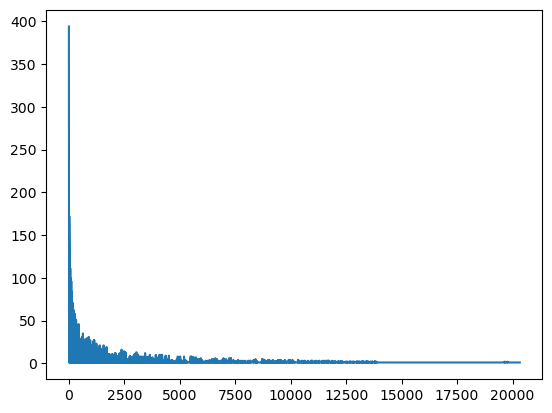

In [1270]:
# pd.DataFrame(
#     true_sybil_df["last_txn_date"].apply(lambda x: pd.to_datetime(x)).value_counts()
# ).sort_index().iloc[1:, :].plot()

# true_sybil_df['commu_tx_wallets'].value_counts().sort_index().plot()  

full_result_df.loc[true_sybil_lst, test_variable].value_counts().sort_index().plot()
full_result_df.loc[true_sybil_lst, test_variable].describe()

count      339.000000
mean      7418.150442
std       8969.611095
min         51.000000
25%       1192.500000
50%       2294.000000
75%      20738.500000
max      23531.000000
Name: community, dtype: float64

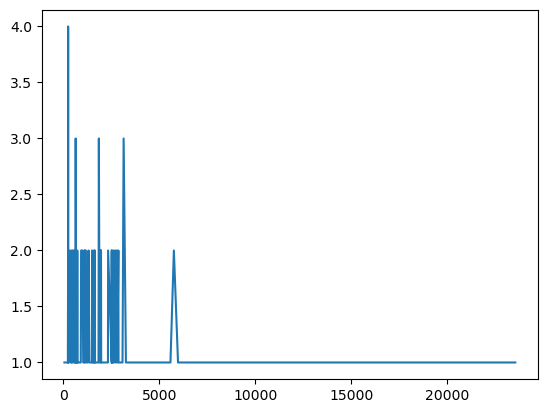

In [1271]:
# pd.DataFrame(
#     true_normal_df["last_txn_date"].apply(lambda x: pd.to_datetime(x)).value_counts()
# ).sort_index().iloc[1:, :].plot()

# true_normal_df['total_txn'].value_counts().sort_index().plot()  

full_result_df.loc[true_normal_lst, test_variable].value_counts().sort_index().plot()
full_result_df.loc[true_normal_lst, test_variable].describe()

In [1272]:
full_result_df.loc[true_normal_lst]

,community,type,commu_tx_wallets,commu_tx_count,gas_fee,total_txn,unique_tokens,last_txn_date,unique_active_days,answer
0x9270f540465411d6c217ef563fcc6a482c28d1ee,51.0,normal,1.0,1.0,2.226604,72.0,45.0,2024-06-20,39.0,airdrop
0x13c8c8a27b6e90a344e252d7fce5c612e86640a5,226.0,normal,20.0,40.0,5.643044,106.0,28.0,2024-06-23,27.0,airdrop
0x414545c9c201af809cb1e048d9085fffc78e416a,232.0,normal,4.0,5.0,2.992689,100.0,40.0,2024-06-20,28.0,airdrop
0x1a0ce18085a3a7979e87bb4ccfb50df165b44933,245.0,normal,1.0,1.0,10.408329,64.0,28.0,2024-06-13,17.0,airdrop
0xdb0887f4f05f98552f7f020c66d8b2e7062a6e44,245.0,normal,4.0,7.0,0.496806,26.0,9.0,2024-03-31,9.0,airdrop
...,...,...,...,...,...,...,...,...,...,...
0xec2bdeb0ef70cdfdf375d6ac5eb3d94b9be5ae51,22895.0,normal,0.0,0.0,6.202546,76.0,42.0,2024-06-20,24.0,airdrop
0x685da9106e9c9d4349e83ce9be27b169961ff2f1,23077.0,normal,0.0,0.0,1.750376,28.0,14.0,2024-06-20,8.0,airdrop
0x72e130fe55658167f7960a8765ba1b0b35ab78f0,23181.0,normal,0.0,0.0,2.353619,125.0,16.0,2024-06-21,10.0,airdrop
0xf4f9af1933f6068104bd0a8a9623fbd2ad8009b9,23263.0,normal,0.0,0.0,2.308673,74.0,18.0,2024-04-17,14.0,airdrop


count     1982.000000
mean      4835.981332
std       6275.188482
min          1.000000
25%        706.000000
50%       1715.000000
75%       5610.000000
max      20312.000000
Name: community, dtype: float64

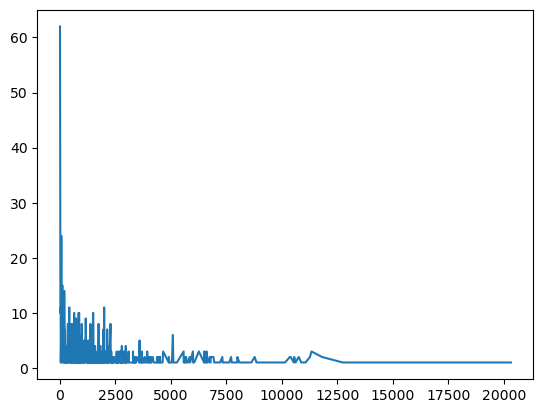

In [1273]:
# pd.DataFrame(
#     false_sybil_df["last_txn_date"].apply(lambda x: pd.to_datetime(x)).value_counts()
# ).sort_index().iloc[1:, :].plot()

# false_sybil_df['total_txn'].value_counts().sort_index().plot()  

full_result_df.loc[false_sybil_lst, test_variable].value_counts().sort_index().plot()
full_result_df.loc[false_sybil_lst, test_variable].describe()

count     1272.000000
mean     10705.189465
std      10128.774869
min         51.000000
25%       1237.000000
50%       3612.000000
75%      21398.250000
max      23957.000000
Name: community, dtype: float64

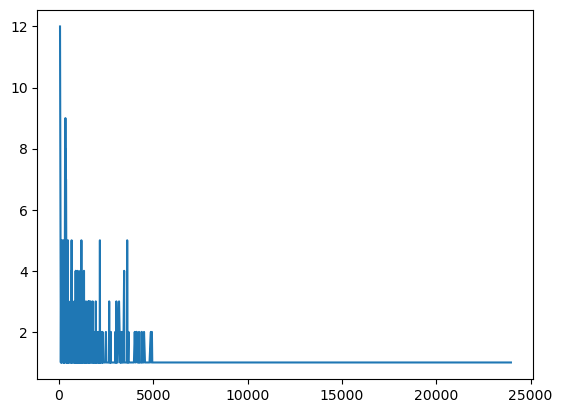

In [1274]:
# pd.DataFrame(
#     false_normal_df["last_txn_date"].apply(lambda x: pd.to_datetime(x)).value_counts()
# ).sort_index().iloc[1:, :].plot()

# false_normal_df['total_txn'].value_counts().sort_index().plot()  

full_result_df.loc[false_normal_lst, test_variable].value_counts().sort_index().plot()
full_result_df.loc[false_normal_lst, test_variable].describe()

In [1275]:
full_result_df.loc[false_normal_lst]

,community,type,commu_tx_wallets,commu_tx_count,gas_fee,total_txn,unique_tokens,last_txn_date,unique_active_days,answer
0x04668fc8e555dbec20f2bb42a3c72b4b7b194d97,51.0,normal,1.0,1.0,2.066047,34.0,19.0,2024-03-28,13.0,sybil
0x28079f423f5a7242459f77b1c42f8b0de8269905,51.0,normal,2.0,2.0,0.950762,18.0,10.0,2024-05-11,8.0,sybil
0x393945fcab9652221b90444959fa1ea0963425f7,51.0,normal,1.0,1.0,1.640516,90.0,26.0,2024-06-28,57.0,sybil
0x4a94f237f1e430bb100ed1732e75b51f172c90d8,51.0,normal,1.0,1.0,2.210230,60.0,27.0,2024-05-11,36.0,sybil
0x59f5d24375fd249e857fc70ffdf7f44a0b49af65,51.0,normal,1.0,1.0,0.418141,18.0,14.0,2023-12-21,12.0,sybil
...,...,...,...,...,...,...,...,...,...,...
0xd6ed687fb45dcbe13784812d7c088a30ed0ca904,23946.0,normal,0.0,0.0,0.666204,20.0,14.0,2024-04-29,6.0,sybil
0xf0d939b52cde10a96c8276422cf248b42c587d88,23947.0,normal,0.0,0.0,1.147547,24.0,18.0,2024-04-29,8.0,sybil
0xe335047dd2ca52363cb3a61515c66ea5a6085a45,23955.0,normal,0.0,0.0,0.371875,13.0,10.0,2024-04-27,11.0,sybil
0xf358dcab2973c031b91be455eeb7f863a6274b20,23956.0,normal,0.0,0.0,2.739630,50.0,25.0,2024-06-30,30.0,sybil


In [1276]:
full_result_df[full_result_df['community'] == 1].answer.value_counts()

sybil      394
airdrop     62
Name: answer, dtype: int64

In [1277]:
answer_sybil_df = full_result_df[full_result_df["answer"] == "sybil"]
answer_airdrop_df = full_result_df[full_result_df["answer"] == "airdrop"]

<Axes: >

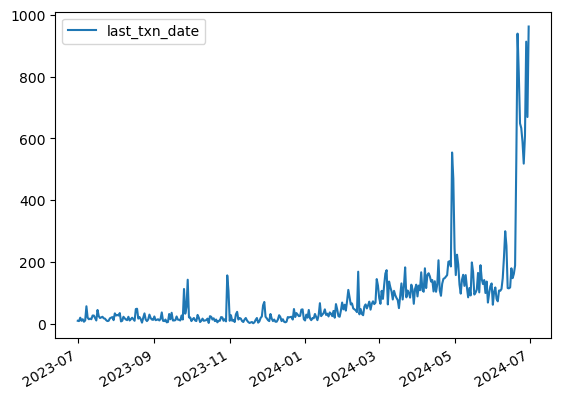

In [1278]:
pd.DataFrame(
    answer_sybil_df["last_txn_date"].apply(lambda x: pd.to_datetime(x)).value_counts()
).sort_index().iloc[1:, :].plot()

<Axes: >

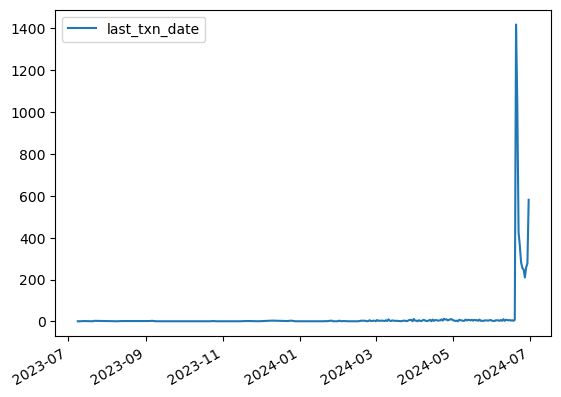

In [1279]:
pd.DataFrame(
    answer_airdrop_df["last_txn_date"].apply(lambda x: pd.to_datetime(x)).value_counts()
).sort_index().iloc[1:, :].plot()

In [1280]:
pd.DataFrame(
    answer_airdrop_df["last_txn_date"].apply(lambda x: pd.to_datetime(x)).value_counts()
).sort_index()

,last_txn_date
1970-01-01,2
2023-07-09,1
2023-07-11,1
2023-07-14,2
2023-07-19,1
...,...
2024-06-26,248
2024-06-27,210
2024-06-28,258
2024-06-29,277


In [1281]:
full_result_df[full_result_df["community"] == 98]

,community,type,commu_tx_wallets,commu_tx_count,gas_fee,total_txn,unique_tokens,last_txn_date,unique_active_days,answer
0x0cb9ada4c88885f613297512f6ed5d1b79acec11,98.0,sybil_core,99.0,170.0,80.857081,894.0,156.0,2024-06-13,105.0,sybil


In [1282]:
obs_community_lst = full_result_df[full_result_df["community"] == 23].index.tolist()
obs_community_df = weight_df[
    weight_df["node_a"].isin(obs_community_lst)
    | weight_df["node_b"].isin(obs_community_lst)
]

obs_false_positive_lst = full_result_df.loc[obs_community_lst][
    (full_result_df["type"] == "normal") & (full_result_df["answer"] == "sybil")
].index.tolist()

obs_false_negative_lst = full_result_df.loc[obs_community_lst][
    (full_result_df["type"] == "sybil") & (full_result_df["answer"] == "airdrop")
].index.tolist()


community_visualization_2d(
    obs_community_df,
    obs_false_positive_lst,
    obs_false_negative_lst,
    weight_=800,
    height_=500,
)

In [1283]:
weight_df

,count,node_a,node_b,weight
0,2,0x0000000000000000000000000000000000002105,0x4b67945a88b434f22ec1308ad89769fd35127a5f,0.00232
1,1,0x0000000000000000000000000000000064c8f444,0x81ab9d56c5a7f268a9ea5e3fe233771423754895,0.00116
2,1,0x0000000000000000000000000000000066353a2b,0x4b67945a88b434f22ec1308ad89769fd35127a5f,0.00116
3,1,0x000000000000000000000000000000009b476a5d,0x4b67945a88b434f22ec1308ad89769fd35127a5f,0.00116
4,1,0x000000000000000000000000000000009b477880,0x4b67945a88b434f22ec1308ad89769fd35127a5f,0.00116
...,...,...,...,...
264475,1,0xfecfcab98fd25c78049a1b567301e8437d0652c9,0xff5df410e4c72c1b49a2adfc3e3a8ef9511c9292,0.00116
264476,2,0xfee0f7dd0df74723c681e23ff6c6410b4f23ff57,0xff8ba4d1fc3762f6154cc942ccf30049a2a0cec6,0.00232
264477,1,0xff1cff02332f6f23c93551a3ef70d99cbb6fcc80,0xff629ead0ce217e4e99e1714e09be41dd387c1d8,0.00116
264478,1,0xff8ba4d1fc3762f6154cc942ccf30049a2a0cec6,0xff994f1271ca94fd232b89adef52023b41fef4bf,0.00116


# Playground